In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

# Load datasets

In [2]:
# data paths
articles_path = "data/articles.csv"
customers_path = "data/customers.csv"
submission_path = "data/sample_submission.csv"
transactions_path = "data/transactions_train.csv"

# datasets
articles = pd.read_csv(articles_path)
customers = pd.read_csv(customers_path)
submission = pd.read_csv(submission_path)
transactions = pd.read_csv(transactions_path)


# Articles Exploration

### Data type verification

In [4]:
print(articles.info())
print("\nArticles are described with different attributes which are encoded.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   article_id                    105542 non-null  int64 
 1   product_code                  105542 non-null  int64 
 2   prod_name                     105542 non-null  object
 3   product_type_no               105542 non-null  int64 
 4   product_type_name             105542 non-null  object
 5   product_group_name            105542 non-null  object
 6   graphical_appearance_no       105542 non-null  int64 
 7   graphical_appearance_name     105542 non-null  object
 8   colour_group_code             105542 non-null  int64 
 9   colour_group_name             105542 non-null  object
 10  perceived_colour_value_id     105542 non-null  int64 
 11  perceived_colour_value_name   105542 non-null  object
 12  perceived_colour_master_id    105542 non-null  int64 
 13 

In [126]:
# Collect attributes that have -1 values
strange_cols = [("product_type_name","product_type_no"), 
                ("graphical_appearance_name","graphical_appearance_no"), 
                ("colour_group_name", "colour_group_code"), 
                ("perceived_colour_value_name", "perceived_colour_value_id"), 
                ("perceived_colour_master_name", "perceived_colour_master_id")]
res = []
# Check what -1 values are assigned to
for pair in strange_cols:
    df = articles.loc[:,pair]
    name = df[pair[0]].iloc[np.where(df[pair[1]]==-1)[0]].unique()
    res.append(name.item())
res


['Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown']

### Check for NAs

In [5]:
print(articles.isna().sum())
print("\nOnly detail_desc misses values it won't be taken inot account during training. \n\
The column will be dropped as it is expected that it won't provide any valuable information")

article_id                        0
product_code                      0
prod_name                         0
product_type_no                   0
product_type_name                 0
product_group_name                0
graphical_appearance_no           0
graphical_appearance_name         0
colour_group_code                 0
colour_group_name                 0
perceived_colour_value_id         0
perceived_colour_value_name       0
perceived_colour_master_id        0
perceived_colour_master_name      0
department_no                     0
department_name                   0
index_code                        0
index_name                        0
index_group_no                    0
index_group_name                  0
section_no                        0
section_name                      0
garment_group_no                  0
garment_group_name                0
detail_desc                     416
dtype: int64

Only detail_desc misses values it won't be taken inot account during training. 
The co

### Check number of unique values for each column

In [6]:
articles.nunique()

article_id                      105542
product_code                     47224
prod_name                        45875
product_type_no                    132
product_type_name                  131
product_group_name                  19
graphical_appearance_no             30
graphical_appearance_name           30
colour_group_code                   50
colour_group_name                   50
perceived_colour_value_id            8
perceived_colour_value_name          8
perceived_colour_master_id          20
perceived_colour_master_name        20
department_no                      299
department_name                    250
index_code                          10
index_name                          10
index_group_no                       5
index_group_name                     5
section_no                          57
section_name                        56
garment_group_no                    21
garment_group_name                  21
detail_desc                      43404
dtype: int64

The results indicate that in some cases the number of the values in the encoder column does not correspond to the number of the values in the name columns. Some names consists multiple encoders. The ultimate goal is to use encoder columns as it would be efficient in terms of memory.

### Check for duplicates

In this section I decided to check whether some articles share multiple ids. The aim of this dataset is to store unique articles and their describtions therefore there shouldn't be any duplicates.

In [10]:
# Columns without id 
cols = list(articles.columns)
cols.remove('article_id')

# Indices of duplicated rows
duplicated_rows = np.where(articles.duplicated(subset=cols, keep=False))[0]
print("There are {} duplicates".format(len(duplicated_rows)))

There are 9369 duplicates


In [9]:
# Reduced dataset with duplicates
duplicated_df = articles.iloc[duplicated_rows][cols]
first_duplicated_rows = np.where(articles.duplicated(subset=cols, keep="last"))[0]

# Create an empty dictionary to store the tuple of duplicate indices
duplicate_indices = {}

# Iterate through the rows of duplicated_df and group the indices by row values
for index, row in duplicated_df.iterrows():
    row_values = tuple(row)  # Convert the row to a tuple for use as a dictionary key
    if row_values not in duplicate_indices:
        duplicate_indices[row_values] = [index]
    else:
        duplicate_indices[row_values].append(index)

The examination revealed that duplicates occurs in the article dataset therefore it was decided to create a list which consits sets of duplicates which might be useful during examination of the transaction database. But before that it was decided to explore more some attributes.

### Product group name

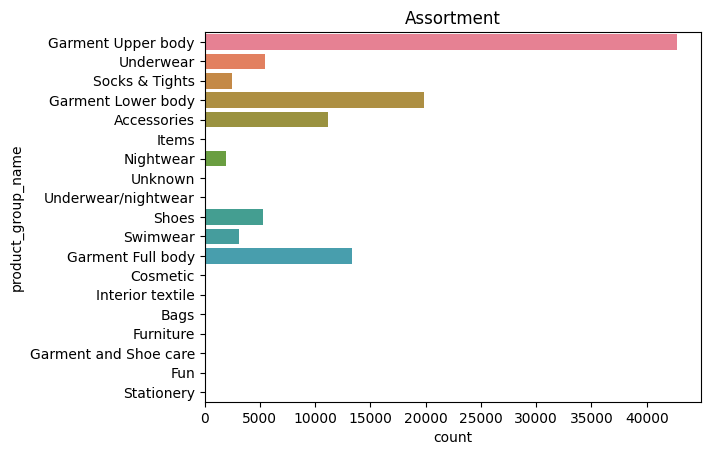

In [40]:
sns.countplot(data=articles, y="product_group_name", hue="product_group_name")
plt.title("Assortment")
plt.show()

The figure indicates that most of the products areassigned to the following groups: 
- Garment Upper body,
- Underwear,
- Docks & Tights,
- Garment Lower body,
- Accessories,
- Nightwear,
- Shoes,
- Swimwear,
- Garments Full body.

### Perceived Color

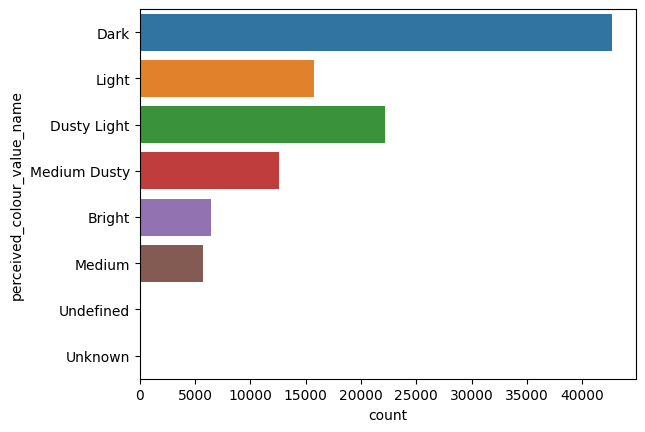

In [40]:
sns.countplot(data=articles, y="perceived_colour_value_name", hue="perceived_colour_value_name")
plt.show()

### Garment group

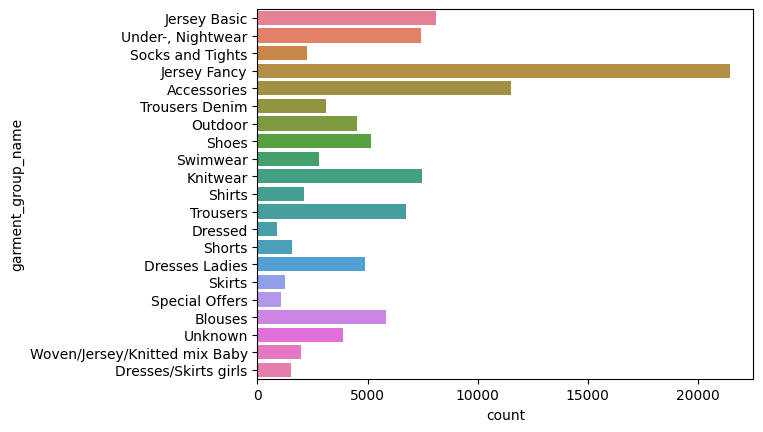

In [38]:
sns.countplot(data=articles, y='garment_group_name', hue='garment_group_name')
plt.show()

### Index group

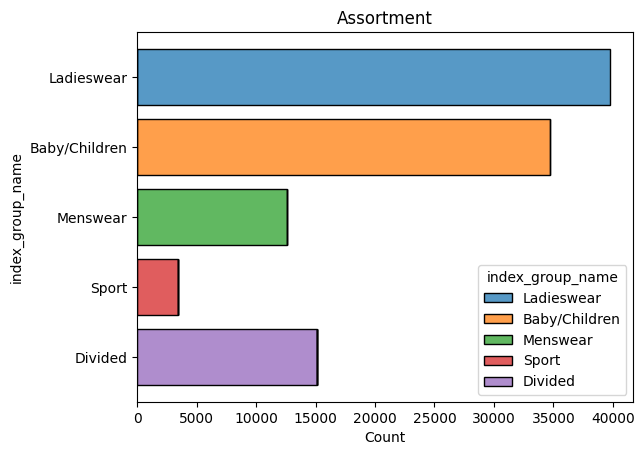

In [128]:
sns.histplot(data=articles, y='index_group_name', hue='index_group_name', multiple='stack', shrink=.8)
plt.title("Assortment")
plt.show()

### Index group & index name

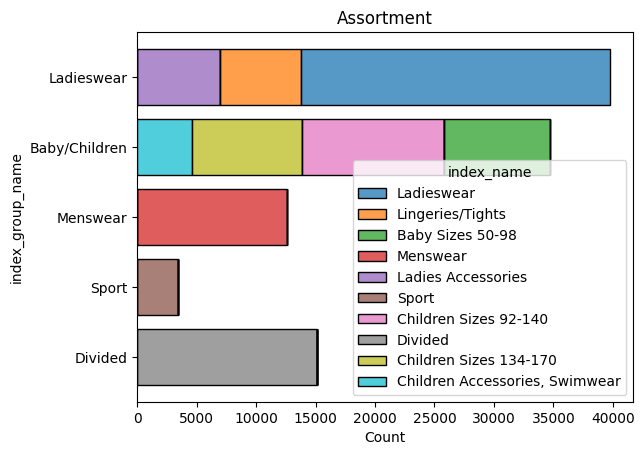

In [129]:
sns.histplot(data=articles, y='index_group_name', hue='index_name', multiple='stack', shrink=.8)
plt.title("Assortment")
plt.show()

### Dealing with encoders

In [12]:
cols = articles.columns
cols = np.delete(cols, [0, 5, len(cols)-1])
encoder_pairs = []

for i in range(0,len(cols),2):
    encoder_pair = (cols[i], cols[i+1])
    encoder_pairs.append(encoder_pair)

bad_encoders = []
for pair in encoder_pairs:
    check = np.any(articles[['product_type_name','product_type_no']].groupby('product_type_no')
                   ['product_type_name'].nunique()>1)
    if check:
        bad_encoders.append(pair)
if not bad_encoders:
    print("All encoders are assigned to one specific name for all attributes!")
else:
    print("These {} should be verified!".format(bad_encoders))

All encoders are assigned to one specific name for all attributes!


### Check how products are assigned to their types

In [36]:
df = articles[["prod_name","product_type_name"]]
name_types = df["prod_name"].unique()
group_names = {}

# Check which product are assigned to product types 
for name in name_types:
    group_names[name] = list(df["product_type_name"].iloc[np.where(df["prod_name"]==name)[0]].unique())

# Check indices for products that are assigne to multiple product types
indices = np.where(np.array([len(group_name) for group_name in list(group_names.values())])>1)[0]
if len(indices)>0:
    type_names = [list(group_names.keys())[indx] for indx in indices]
    group = [list(group_names.values())[indx] for indx in indices]
    print(f"The {len(type_names)} products are assigned to multiple product types!")
else:
    print("There are no products that are assigned to multiple product types")

The 824 products are assigned to multiple product types!


### Check how product types are assigned to their groups

In [37]:
df = articles[["product_type_name","product_group_name"]]
name_types = df["product_type_name"].unique()
group_names = {}

# Check which product types are assigned to product group 
for name in name_types:
    group_names[name] = list(df["product_group_name"].iloc[np.where(df["product_type_name"]==name)[0]].unique())

# Check indices for product types that are assigne to multiple product groups
indices = np.where(np.array([len(group_name) for group_name in list(group_names.values())])>1)[0]
if len(indices)>0:
    type_names = [list(group_names.keys())[indx] for indx in indices]
    group = [list(group_names.values())[indx] for indx in indices]
    print(f"The {type_names} is assigned to multiple groups {group}!")
else:
    print("There are no product types that are assigned to multiple product groups")

The ['Umbrella'] is assigned to multiple groups [['Items', 'Accessories']]!


# Customers Exploration

### Data type exploration

In [49]:
print(customers.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371980 entries, 0 to 1371979
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   customer_id             1371980 non-null  object 
 1   FN                      476930 non-null   float64
 2   Active                  464404 non-null   float64
 3   club_member_status      1365918 non-null  object 
 4   fashion_news_frequency  1355969 non-null  object 
 5   age                     1356119 non-null  float64
 6   postal_code             1371980 non-null  object 
dtypes: float64(3), object(4)
memory usage: 73.3+ MB
None


In [31]:
round(customers.describe(),0)

             FN    Active        age
count  476930.0  464404.0  1356119.0
mean        1.0       1.0       36.0
std         0.0       0.0       14.0
min         1.0       1.0       16.0
25%         1.0       1.0       24.0
50%         1.0       1.0       32.0
75%         1.0       1.0       49.0
max         1.0       1.0       99.0
13


### Check for NAs

In [13]:
print(customers.isna().sum()/len(customers))


customer_id               0.000000
FN                        0.652378
Active                    0.661508
club_member_status        0.004418
fashion_news_frequency    0.011670
age                       0.011561
postal_code               0.000000
dtype: float64


### Check for number of uniques values

In [182]:
print(customers.nunique())

customer_id               1371980
FN                              1
Active                          1
club_member_status              3
fashion_news_frequency          3
age                            84
postal_code                352899
dtype: int64


In [39]:
cols = ['club_member_status', 'fashion_news_frequency']
unique_vals = {"club_member_status": [], "fashion_news_frequency": []}
for col in cols:
    unique_vals[col] = customers[col].unique()
pd.DataFrame(unique_vals)

club_member_status fashion_news_frequency
0             ACTIVE                   NONE
1                NaN              Regularly
2         PRE-CREATE                    NaN
3          LEFT CLUB                Monthly

### Pie chart for Club Member Status

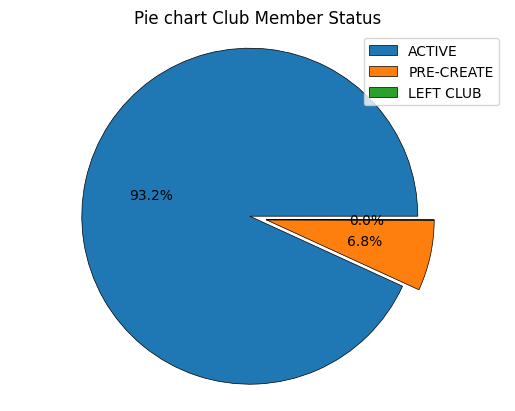

In [214]:
value_counts = customers["club_member_status"].value_counts()
explode = [0.1, 0, 0]
plt.pie(value_counts, labels=None, autopct='%1.1f%%', explode=explode,
        wedgeprops = {"edgecolor" : "black",
                      'linewidth': 0.5,
                      'antialiased': True})

plt.legend(value_counts.index, loc="best")
plt.title("Pie chart Club Member Status")

# Show the plot
plt.show()

### Pie chart for Fashion News Frequency

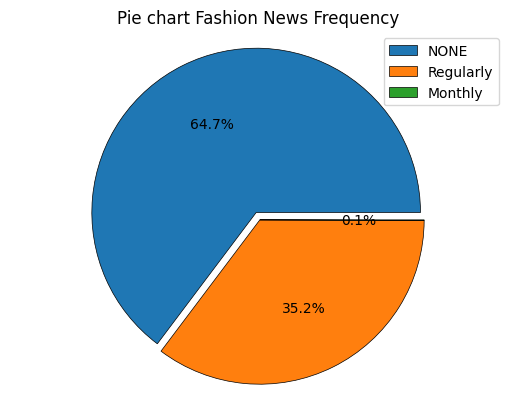

In [231]:
value_counts = customers["fashion_news_frequency"].value_counts()
explode = [0.05, 0, 0]
plt.pie(value_counts, labels=None, autopct='%1.1f%%', explode=explode,
        wedgeprops = {"edgecolor" : "black",
                      'linewidth': 0.5,
                      'antialiased': True})

plt.legend(value_counts.index, loc="best")
plt.title("Pie chart Fashion News Frequency")
plt.axis('equal')

# Show the plot
plt.show()

### Density of customers age

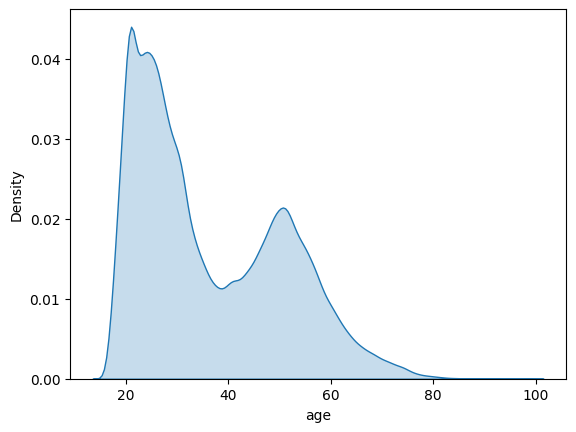

In [228]:
sns.kdeplot(data=customers, x="age", fill=True)
plt.show()

### Verification of the age distribution depending on the club member status

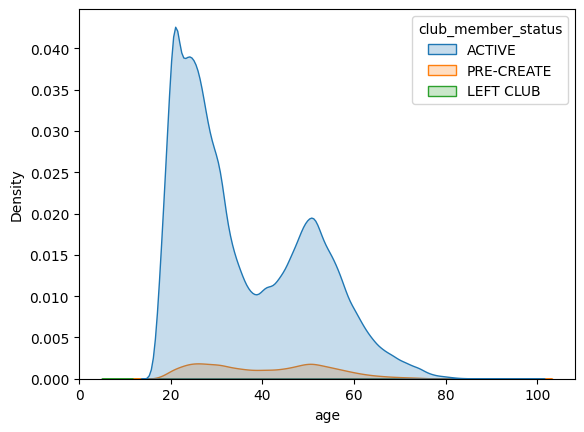

In [226]:
sns.kdeplot(data=customers, x="age", fill=True, hue="club_member_status")
plt.show()

### Verification of the age distribution depending on the fashion news frequency

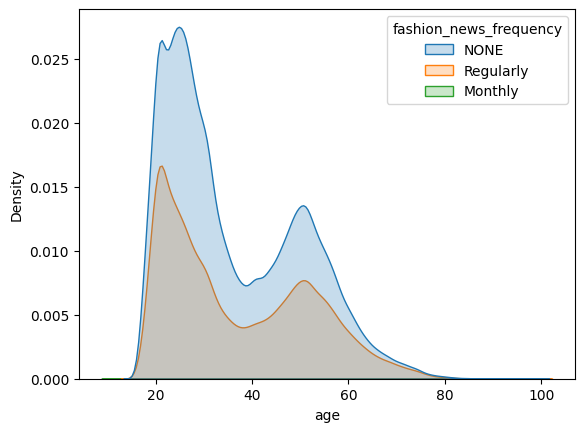

In [225]:
sns.kdeplot(data=customers, x="age", fill=True, hue="fashion_news_frequency")
plt.show()

### Normalized value counts of the postal code

In [75]:
round(customers["postal_code"].value_counts(normalize=True, sort=True, ascending=False, dropna=False),6)

postal_code
2c29ae653a9282cce4151bd87643c907644e09541abc28ae87dea0d1f6603b1c    0.087686
cc4ed85e30f4977dae47662ddc468cd2eec11472de6fac5ec985080fd92243c8    0.000190
714976379549eb90aae4a71bca6c7402cc646ae7c40f6c1cb91d4b5a18623fc1    0.000116
7c1fa3b0ec1d37ce2c3f34f63bd792f3b4494f324b6be5d1e4ba6a75456b96a7    0.000114
5b7eb31eabebd3277de632b82267286d847fd5d44287ee150bb4206b48439145    0.000114
                                                                      ...   
16dd7e391f305b54c01ffed87c189e33de83158d0a808d1b346222703742f638    0.000001
5ce1c699380b3c13655347c9636043f5e64ec2538a1ee7d42dd253a584577630    0.000001
afdedc642d01efeefec6fc8d3394724a71888ebd0ff0311eff6f34946589479d    0.000001
4c8838d278d23029c920b9684fa4cf30a532428a445afb300eeb288685cf00e1    0.000001
0a1a03306fb2f62164c2a439b38c0caa64b40deaae868799ccb93ac69444b79d    0.000001
Name: proportion, Length: 352899, dtype: float64

# Transactions

### Info about data

In [79]:
print(transactions.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31788324 entries, 0 to 31788323
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   t_dat             object 
 1   customer_id       object 
 2   article_id        int64  
 3   price             float64
 4   sales_channel_id  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.2+ GB
None


In [57]:
transactions["t_dat"] = pd.to_datetime(transactions["t_dat"])
round(transactions.describe(),2)

t_dat    article_id        price  \
count                       31788324  3.178832e+07  31788324.00   
mean   2019-09-15 17:27:46.894452992  6.962272e+08         0.03   
min              2018-09-20 00:00:00  1.087750e+08         0.00   
25%              2019-03-28 00:00:00  6.328030e+08         0.02   
50%              2019-08-25 00:00:00  7.145820e+08         0.03   
75%              2020-03-29 00:00:00  7.865240e+08         0.03   
max              2020-09-22 00:00:00  9.562170e+08         0.59   
std                              NaN  1.334480e+08         0.02   

       sales_channel_id  
count       31788324.00  
mean               1.70  
min                1.00  
25%                1.00  
50%                2.00  
75%                2.00  
max                2.00  
std                0.46

### Check for NAs

In [80]:
print(transactions.isna().sum())

t_dat               0
customer_id         0
article_id          0
price               0
sales_channel_id    0
dtype: int64


### Check if all article_ids are in the Articles database

In [45]:
# Calculate set differences
difference = set(transactions["article_id"]) - set(articles["article_id"])
if not difference:
    print("All article_ids are present in the Article database!")
else:
    print("The {} article_ids are missing in the Article database!".format(difference))

All article_ids are present in the Article database!


### Check if all customers are present in the Customers database

In [38]:
# Calulate set differences
difference = set(transactions["customer_id"]) - set(customers["customer_id"])
if not difference:
    print("All customers are present in the Customers database!")
else:
    print("The {} customer_ids are missing in the Customers database!".format(difference))

All customers are present in the Customers database!


### Sales distribution among customers

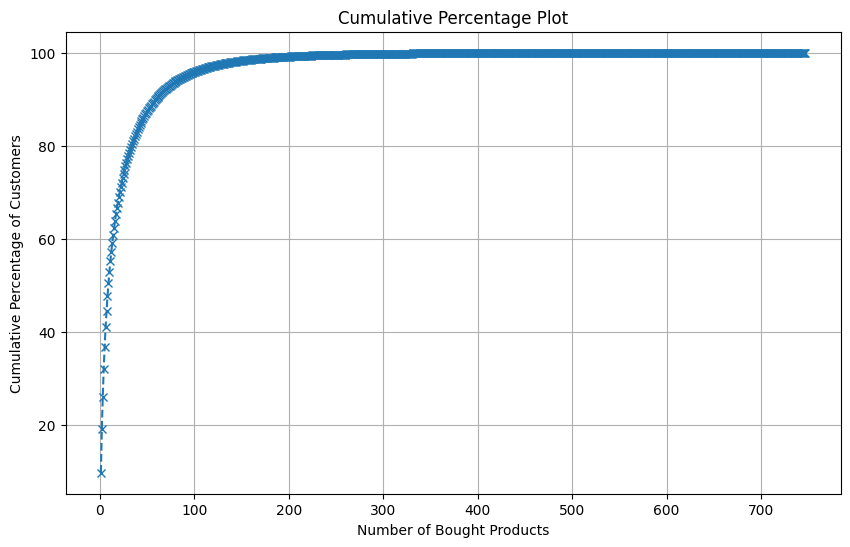

In [132]:
customer_sales_counts = transactions["customer_id"].value_counts()
perc = customer_sales_counts.value_counts()/np.sum(customer_sales_counts.value_counts().values)*100
# Calculate the cumulative sum of the data
cumulative_sum = np.cumsum(perc)

# Create a cumsum plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_sum) + 1), cumulative_sum, marker='x', linestyle='--')
plt.title('Cumulative Percentage Plot')
plt.xlabel('Number of Bought Products')
plt.ylabel('Cumulative Percentage of Customers')
plt.grid(True)

plt.show()

In [83]:
reg_prop = np.sum(transactions["customer_id"].value_counts()>1)/len(transactions["customer_id"].value_counts())
one_time_cons = 1 - reg_prop
print("{}% of customers had only one transaction!".format(round(one_time_cons*100,2)))

9.65% of customers had only one transaction!


### Customer's sales channel prefernces

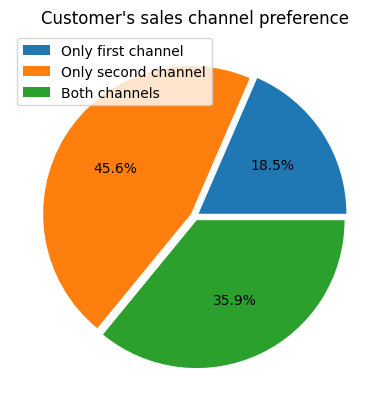

In [35]:
# Check which customers use only first channel
one_channel = transactions[["customer_id","sales_channel_id"]].groupby('customer_id')['sales_channel_id'].apply(lambda x: (x == 1).all()).reset_index()
one_channel_indx = np.where(one_channel["sales_channel_id"])[0]
# Check which customers use only second channel
two_channel = transactions[["customer_id","sales_channel_id"]].groupby('customer_id')['sales_channel_id'].apply(lambda x: (x == 2).all()).reset_index()
two_channel_indx = np.where(two_channel["sales_channel_id"])[0]
# Plot distribution
channel_prop = {"Type": ["Only first channel","Only second channel","Both channels"], "Counts": [len(one_channel_indx),len(two_channel_indx),len(customers)-len(one_channel_indx)-len(two_channel_indx)]}
explode = [0.03,0.03,0.03]
plt.pie(channel_prop["Counts"], autopct='%1.1f%%', explode=explode)
plt.legend(channel_prop["Type"])
plt.title("Customer's sales channel preference")
plt.show()

### Preparing datasets to merge by dropping unncessary columns

In [4]:
articles_sel = articles[['article_id'] + list(articles.select_dtypes(include=['object']).columns)]
articles_sel = articles_sel.drop(columns=["detail_desc", "index_code"])
customers_sel = customers[["customer_id","club_member_status", "fashion_news_frequency", "age", "postal_code"]]

In [5]:
merged_df = transactions.merge(articles_sel, how="inner", on="article_id")
merged_df = merged_df.merge(customers_sel, how="inner", on="customer_id")

### Check sales volume during training period

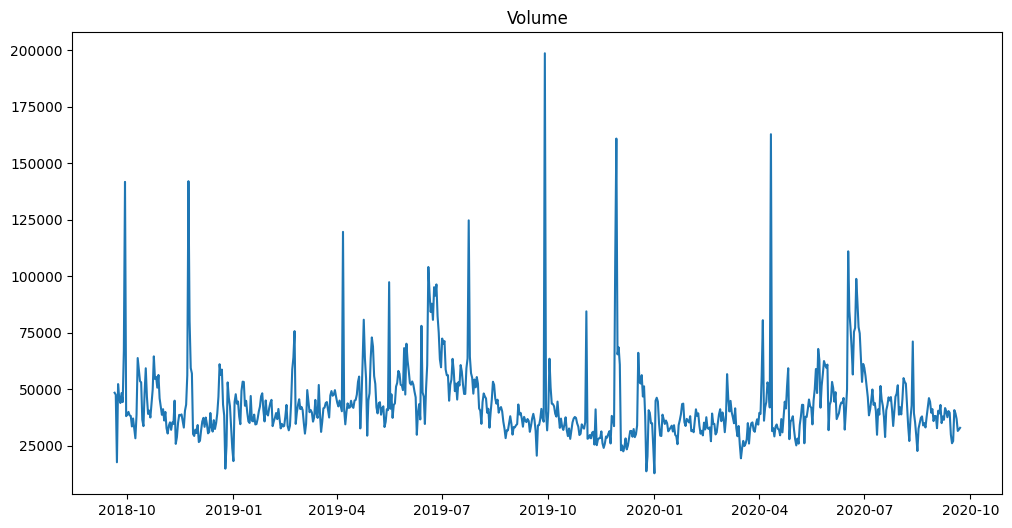

In [6]:
merged_df["t_dat"] = pd.to_datetime(merged_df["t_dat"])
plt.figure(figsize=(12, 6))
plt.plot(merged_df["t_dat"].value_counts().sort_index(), linestyle='-')
plt.title("Volume")
plt.show()

### Check sales during training period

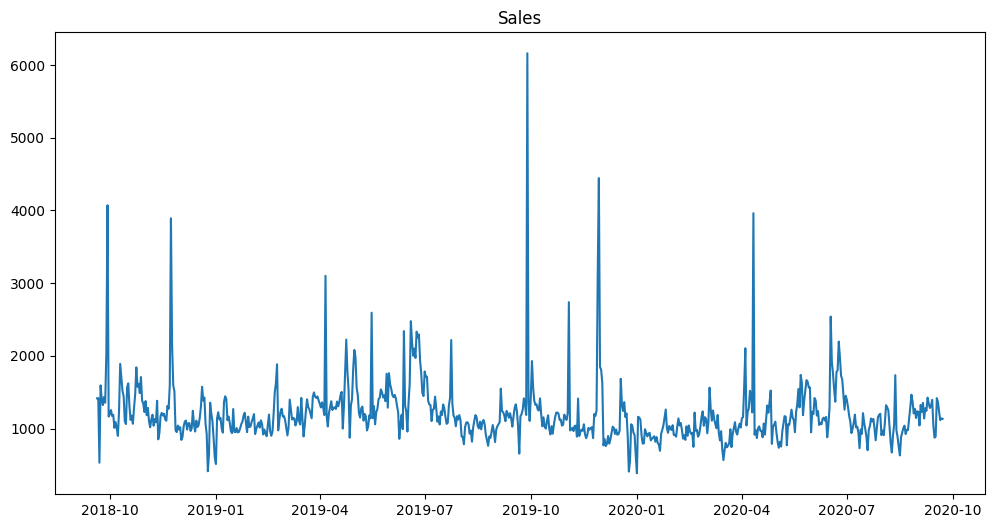

In [237]:
plt.figure(figsize=(12, 6))
plt.plot(merged_df[["t_dat", "price"]].groupby("t_dat").sum(), linestyle='-')
plt.title("Sales")
plt.show()

### Check sales among product groups

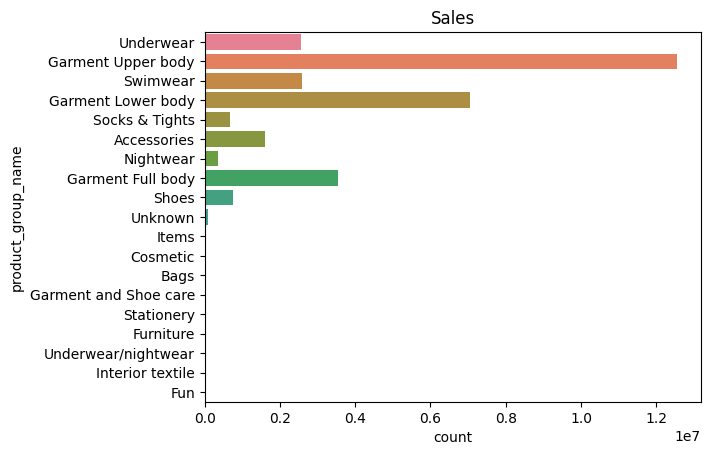

In [46]:
sns.countplot(data=merged_df, y="product_group_name", hue="product_group_name")
plt.title("Sales")
plt.show()

### Divide product groups to investigate sales better

In [48]:
# Get indices for popular and unpopular product groups
popular_prod_indx = np.where(merged_df["product_group_name"].value_counts()>90_000)[0]
unpopular_prod_indx = np.where(merged_df["product_group_name"].value_counts()<90_000)[0]

# Selec popular and unpopular products
popular_prod = merged_df["product_group_name"].value_counts().iloc[popular_prod_indx].index
unpopular_prod = merged_df["product_group_name"].value_counts().iloc[unpopular_prod_indx].index

# Filter datasets
filtered_popular = merged_df[merged_df['product_group_name'].isin(popular_prod)]
filtered_unpopular = merged_df[merged_df['product_group_name'].isin(unpopular_prod)]


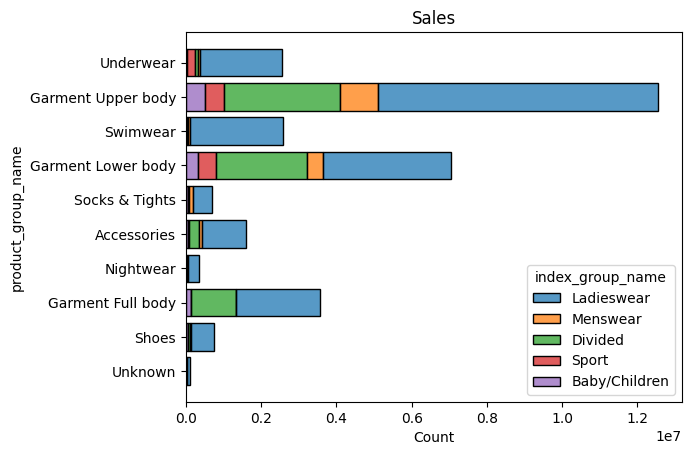

In [49]:
sns.histplot(data=filtered_popular, y="product_group_name", hue="index_group_name", multiple='stack', shrink=.8)
plt.title("Sales")
plt.show()

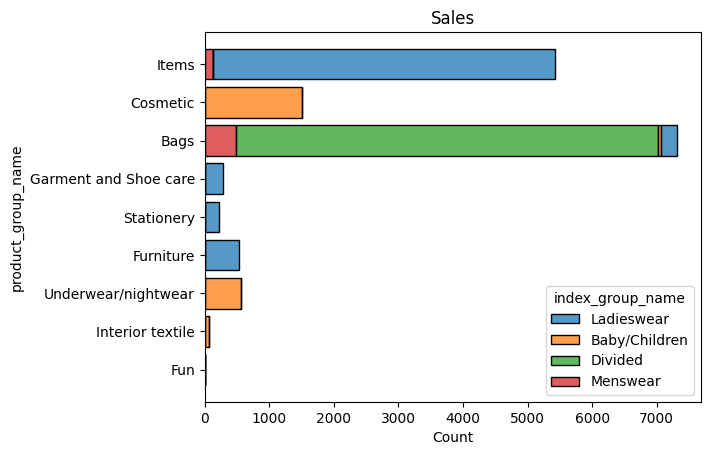

In [50]:
sns.histplot(data=filtered_unpopular, y="product_group_name", hue="index_group_name", multiple='stack', shrink=.8)
plt.title("Sales")
plt.show()

### How sales are distributed by index name depending on the index group name

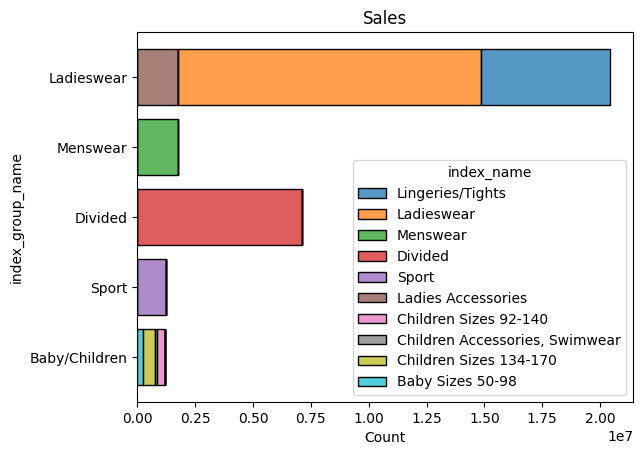

In [130]:
sns.histplot(data=merged_df, y="index_group_name", hue="index_name", multiple='stack', shrink=.8)
plt.title("Sales")
plt.show()

### Which colors are preffered in index groups

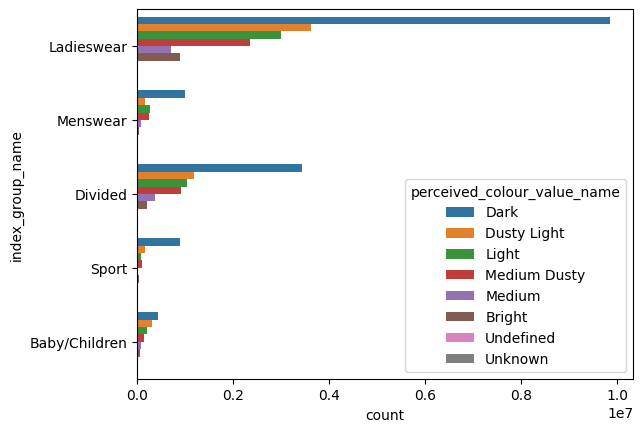

In [253]:
sns.countplot(data=merged_df, y="index_group_name", hue="perceived_colour_value_name")
plt.show()

### Age boxplots depending on the index groups 

<Axes: xlabel='index_group_name', ylabel='age'>

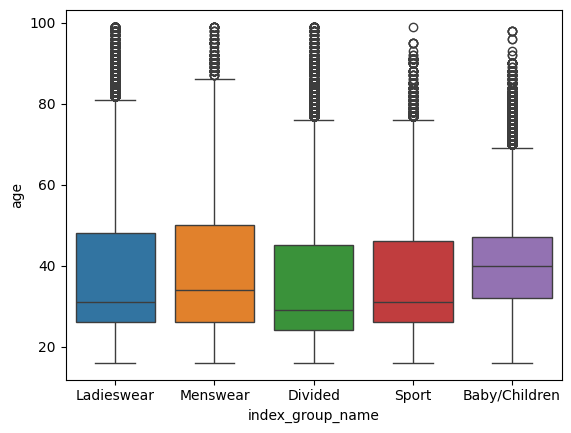

In [276]:
sns.boxplot(merged_df, x="index_group_name", y="age", hue="index_group_name")

### Correlation between Age and Price

In [108]:
# Select dataset we are interested in
merged_age_price = merged_df.loc[:,["age", "price"]]
# Standardize age attribute
merged_age_price["age"] = (merged_age_price["age"] - np.mean(merged_age_price["age"])) / np.std(merged_age_price["age"])
# Calculate spearman's correlation
corr = spearmanr(merged_age_price.dropna())
print("Spearmen's correlation between age and price is equal to {} \n\
and it is not significant as it's p-value is {}.".
format(round(corr.statistic,3), round(corr.pvalue,2)))

Spearmen's correlation between age and price is equal to 0.053 
and it is not significant as it's p-value is 0.0.


### Sales Channel

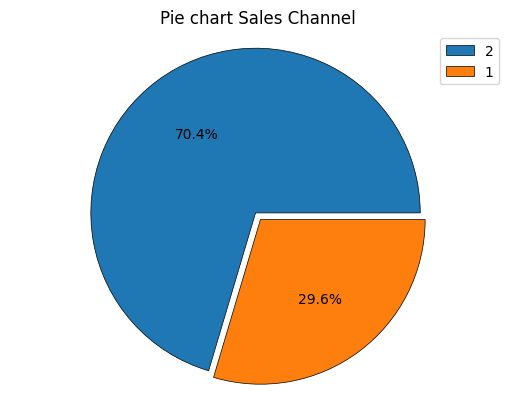

In [138]:
value_counts = merged_df["sales_channel_id"].value_counts()
explode = [0.05, 0]
plt.pie(value_counts, labels=None, autopct='%1.1f%%', explode=explode,
        wedgeprops = {"edgecolor" : "black",
                      'linewidth': 0.5,
                      'antialiased': True})

plt.legend(value_counts.index, loc="best")
plt.title("Pie chart Sales Channel")
plt.axis('equal')

# Show the plot
plt.show()

<Axes: xlabel='count', ylabel='sales_channel_id'>

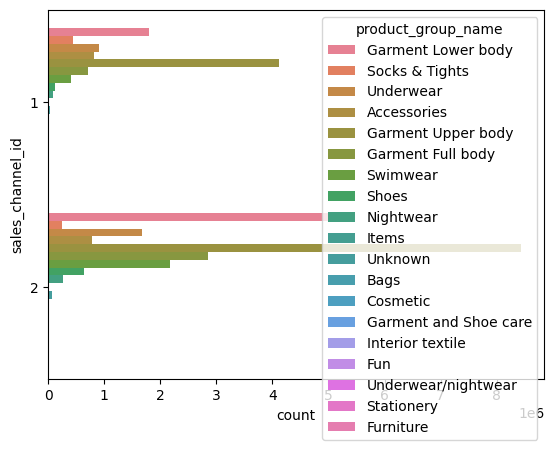

In [141]:
sns.countplot(merged_df, y="sales_channel_id", hue="product_group_name")
plt.show()

<Axes: xlabel='count', ylabel='sales_channel_id'>

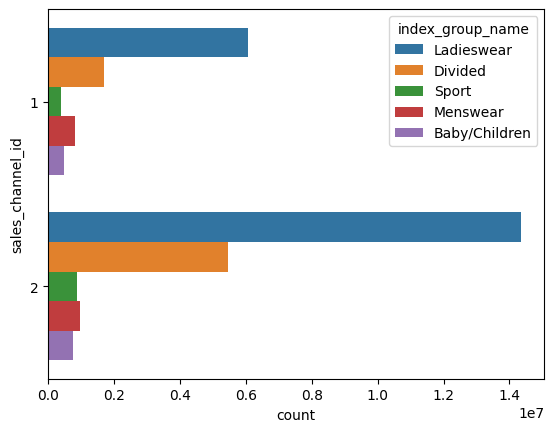

In [142]:
sns.countplot(merged_df, y="sales_channel_id", hue="index_group_name")
plt.show()

### Conclusion:
- Decide if you should use encoded columns - beneficial in terms of memory but to some values multiple encoders are assigned.
- During training verify if more detailed attributes are more informative than grouped ones.
- Decide how to treat unknown values in the article dataset
- Decide how to treat NAs in FN and active status
- Handle unbalanced fashion frequency status and club member status.
